<a href="https://colab.research.google.com/github/fedhere/FDSFE_FBianco/blob/main/ClassDemos/Convolutional_aenc_faces_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

last modified

author FBB for LSDSS2024

# Autoencoder notebook
create superresolution headshots from low resolution  versions in (black and white):
- load a set of images
- lower the resolution to build the input data
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the original (heigher resolution) images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [1]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import Input, Model
from keras import backend as K
from keras.callbacks import EarlyStopping


In [2]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
from tqdm.notebook import tqdm

# not needed on colab
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1A load head shots from known training data from a shared drive if you have access to it

 skip to 1B to load images already read in and turned into a numpy array which you can find in the github repo



In [3]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [4]:
cd /content/gdrive/Shareddrives/LSDSS24/

/content/gdrive/Shareddrives/LSDSS24


In [5]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [6]:
#!unzip faces95.zip

In [7]:
!ls

data	 headshot.png	   imgreconstruct_100000PUS_factor4.h5
faces95  headshot_TED.png  imgreconstruct_flat_100000PUS_factor4.h5


In [8]:
flist = glob.glob("faces95/*/*jpg")

In [9]:
N = len(flist)
N

1140


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

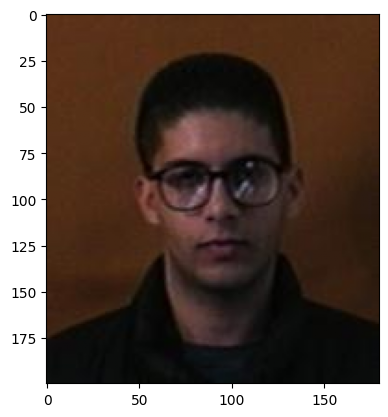

In [10]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

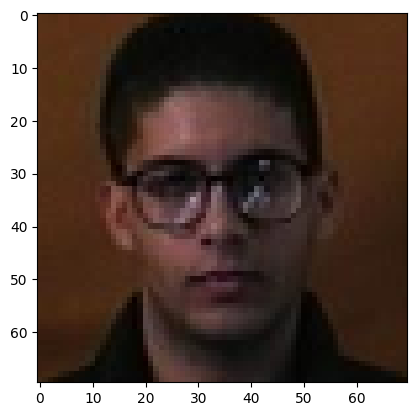

In [11]:
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'>you can skip this and go  straight to loading the images</font>. If you run this you should run this on CPUs, not GPUs, so you do not waste resources

In [12]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [13]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 3))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255
  # here I collect the certain portion of each image
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2].astype(float) / 255
#uncomment this to save another array of images - I saved the original one as data/faces.npy


  0%|          | 0/1140 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#imgs orig is the full resolution image, save a version with axes in powers of 2
#imgs = imgs[:, :-6, :-6, :].mean(axis=3, keepdims=True)
#np.save("data/faces_saved.npy", imgs)

In [ ]:
imgs.shape

# 1B you can read the images below if you have saved them earlier

first, download faces_save.npy and put it in a local folder called data

In [14]:
imgs = np.load("data/faces_saved.npy")
imgs.shape

(1140, 64, 64, 1)

# 2 lower the resolution to build the training set

- sample every 4th pixel
- create a 75/25 train/test set with the command
          train_test_split(input, target, test_size = .25, random_state=1)
          What are the input and output data??

## Meet me at the enf of that to create the autoencoder.

In [15]:
# lower the resolution
imgs_lr = imgs[:,::4,::4]
imgs_lr.shape

(1140, 16, 16, 1)

In [16]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape),

(256, 4096)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

# 3 build a feed forward autoencoder model

In [17]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs,
                                          #test_size = .20, random_state=1)
                                          test_size = .01, random_state=777)

#X_tr = X_tr.reshape(len(X_tr), *X_tr.shape[1:])
#X_te = X_te.reshape(len(X_te), *X_te.shape[1:])
#y_tr = y_tr.reshape(len(y_tr), *y_tr.shape[1:])
#y_te = y_te.reshape(len(y_te), *y_te.shape[1:])

In [18]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1128, 16, 16, 1), (12, 16, 16, 1), (1128, 64, 64, 1), (12, 64, 64, 1))

In [19]:
#each image needs to be unravel into a flat array
X_tr_flat = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te_flat = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr_flat = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te_flat = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [20]:
X_tr_flat.shape, X_te_flat.shape, y_tr_flat.shape, y_te_flat.shape

((1128, 256), (12, 256), (1128, 4096), (12, 4096))

In [21]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model_flat = Sequential()

model_flat.add(Dense(1024, activation='relu', input_dim=256))
model_flat.add(Dense(256, activation='relu'))
model_flat.add(Dense(128, activation='relu', name="bottleneck"))
model_flat.add(Dense(256, activation='relu'))
model_flat.add(Dense(1024, activation='relu'))
model_flat.add(Dense(1024*4, activation='sigmoid'))
model_flat.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
print(model_flat.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │       4,198,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,053,056 (19.28 MB)

 Trainable params: 5,053,056 (19.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=0.0001)

In [24]:
# you can skip this and load the saved model
history_flat = model_flat.fit( X_tr_flat, y_tr_flat, epochs=100000,
                    validation_data=[X_te_flat, y_te_flat],
                    batch_size=16, verbose=1,
                    callbacks=[callback])
#model.save("imgreconstruct_100000PUS.h5")

Epoch 1/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - acc: 0.0000e+00 - loss: 0.0494 - mae: 0.1764 - val_acc: 0.0000e+00 - val_loss: 0.0229 - val_mae: 0.1221
Epoch 2/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.0029 - loss: 0.0218 - mae: 0.1121 - val_acc: 0.0000e+00 - val_loss: 0.0179 - val_mae: 0.1038
Epoch 3/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 8.9927e-04 - loss: 0.0173 - mae: 0.0981 - val_acc: 0.0000e+00 - val_loss: 0.0132 - val_mae: 0.0867
Epoch 4/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.0011 - loss: 0.0133 - mae: 0.0847 - val_acc: 0.0000e+00 - val_loss: 0.0114 - val_mae: 0.0820
Epoch 5/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.0028 - loss: 0.0112 - mae: 0.0773 - val_acc: 0.0000e+00 - val_loss: 0.0097 - val_mae: 0.0748
Epoch 6/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.0051 - loss: 0.0105 - mae: 0.0737 - val_acc: 0.0000e+00 - val_loss: 0.0087 - val_mae: 0.0697
Epoch 7/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

In [25]:
model_flat.save("imgreconstruct_flat_100000PUS_factor4.h5")

In [26]:
def compareinout_flat(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131)
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132)
  ax.imshow(outim[i].reshape(imgs[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133)
  ax.imshow(y_te[i].reshape(imgs[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5 :	input		      prediction		  target


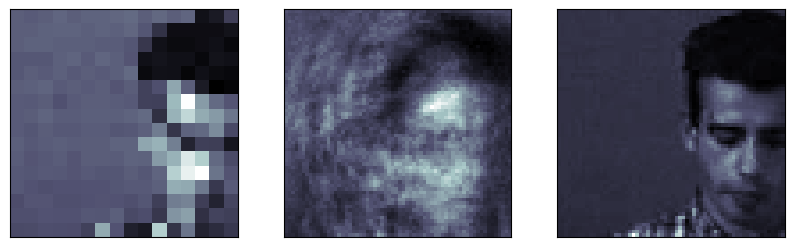

6 :	input		      prediction		  target


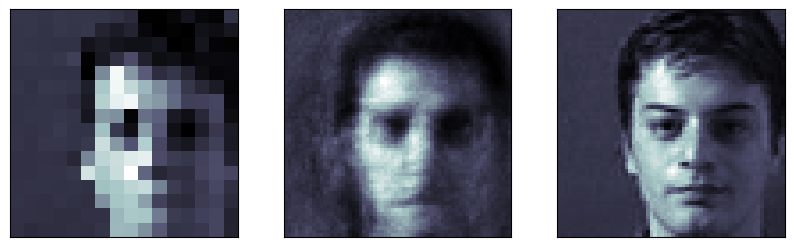

7 :	input		      prediction		  target


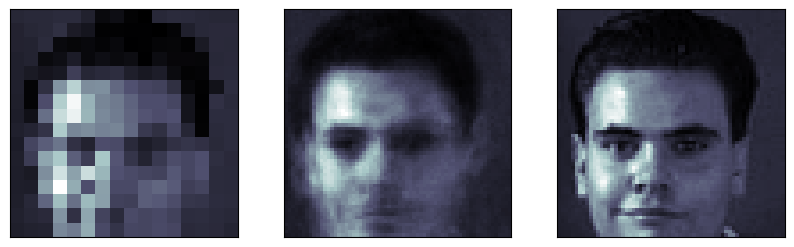

8 :	input		      prediction		  target


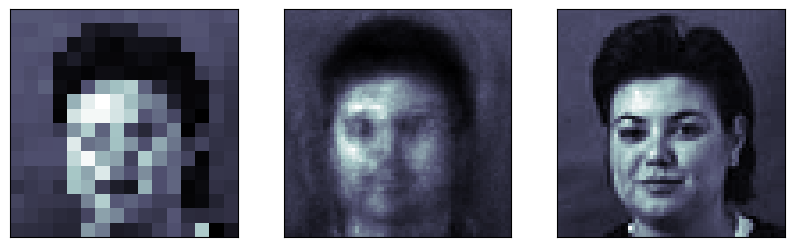

9 :	input		      prediction		  target


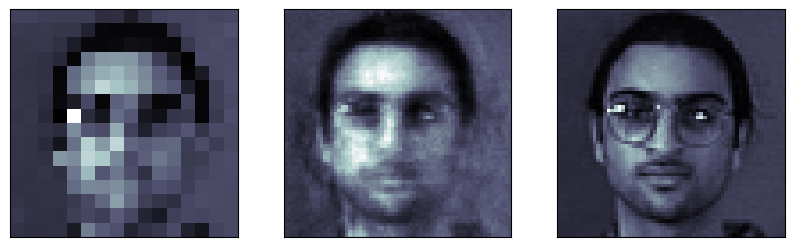

10 :	input		      prediction		  target


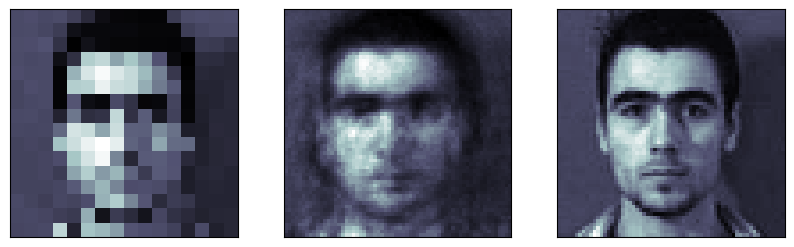

11 :	input		      prediction		  target


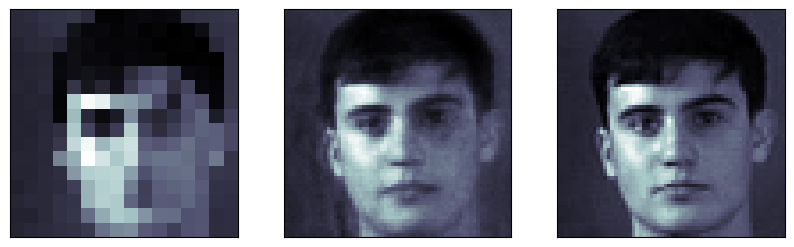

12 :	input		      prediction		  target


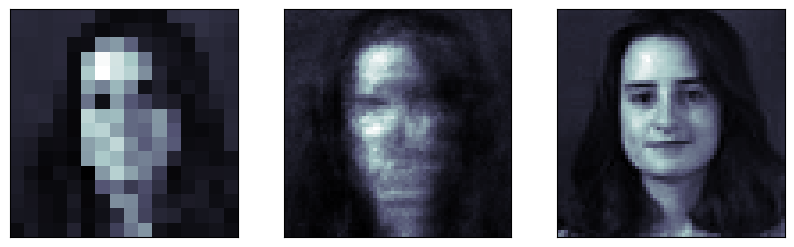

In [29]:
outim = model_flat.predict(X_te_flat)
# pick a few random test images
for i in range(4, len(X_te), 1):
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout_flat(i, outim, X_te_flat)
  pl.show()

# 4 build a convolutional autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [30]:
# this model is 16x16 (input size) -> 64x64 (output size)

model = Sequential()

input_img = Input(shape=X_tr[0].shape)

x = Conv2D(512, (3, 3), activation='relu', padding="same")(input_img)
x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
  #x = layers.Lambda(lambda x: K.mean(x, axis=1))(x1)
  #x = layers.MaxPooling2D((2, 2))(x)
  #x2 = layers.BatchNormalization()(x1)
  #x5 = layers.BatchNormalization()(x4)
encoded = MaxPooling2D((2, 2))(x)


x = Conv2D(128, (3, 3), activation='relu', padding="same")(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = UpSampling2D((2, 2))(x)
#x = layers.Conv2D(128, (3, 3), activation='tanh', padding="same")(x)
x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding="same")(x)

model = Model(input_img, decoded)

model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")


In [31]:
print(model.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 512)         │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 1)           │           2,305 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,957,953 (11.28 MB)

 Trainable params: 2,957,953 (11.28 MB)

 Non-trainable params: 0 (0.00 B)

None


## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [32]:
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=1e-6)

In [33]:
# you can skip this and load the saved model
history = model.fit(X_tr, y_tr, epochs=100000,
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])


Epoch 1/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - acc: 1.5349e-05 - loss: 0.0748 - mae: 0.2198 - val_acc: 0.0000e+00 - val_loss: 0.0122 - val_mae: 0.0862
Epoch 2/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - acc: 1.2596e-05 - loss: 0.0129 - mae: 0.0848 - val_acc: 0.0000e+00 - val_loss: 0.0062 - val_mae: 0.0564
Epoch 3/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - acc: 1.3337e-05 - loss: 0.0082 - mae: 0.0628 - val_acc: 0.0000e+00 - val_loss: 0.0054 - val_mae: 0.0493
Epoch 4/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - acc: 1.3227e-05 - loss: 0.0071 - mae: 0.0572 - val_acc: 0.0000e+00 - val_loss: 0.0052 - val_mae: 0.0500
Epoch 5/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - acc: 1.4767e-05 - loss: 0.0066 - mae: 0.0541 - val_acc: 0.0000e+00 - val_loss: 0.0046 - val_mae: 0.0445
Epoch 6/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - acc: 1.3417e-05 - loss: 0.0060 - mae: 0.0514 - val_acc: 0.0000e+00 - val_loss: 0.0044 - val_mae: 0.0433
Epoch 7/100000
71/71 ━━━━━━━━━━━

In [ ]:
model.save("imgreconstruct_100000PUS_factor4.h5")

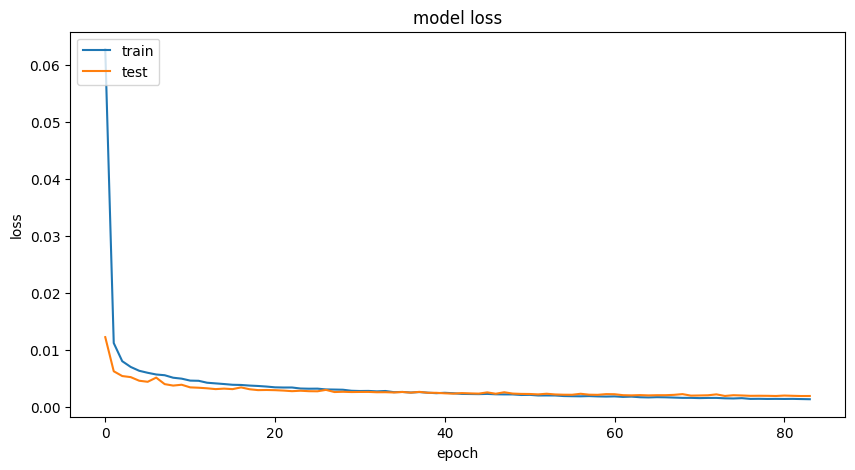

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

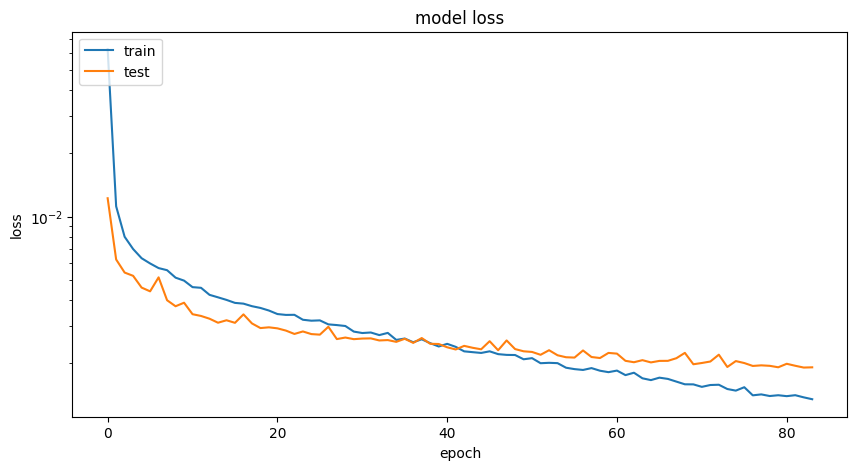

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

In [ ]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
#model.load_weights("data/conv_imgreconstruct_10000.h5")

## predict

In [36]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131)
  ax.imshow(X_te[i], cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132)
  ax.imshow(outim[i], cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133)
  ax.imshow(y_te[i], cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


In [37]:
outim = model.predict(X_te)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


2 :	input		      prediction		  target


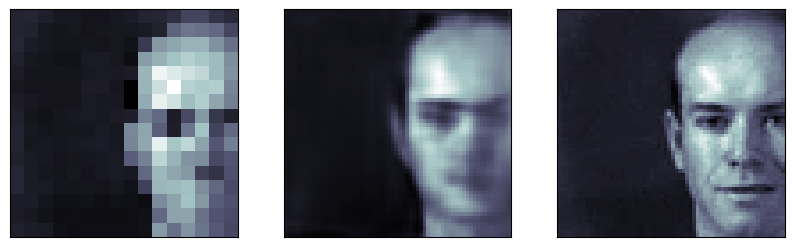

3 :	input		      prediction		  target


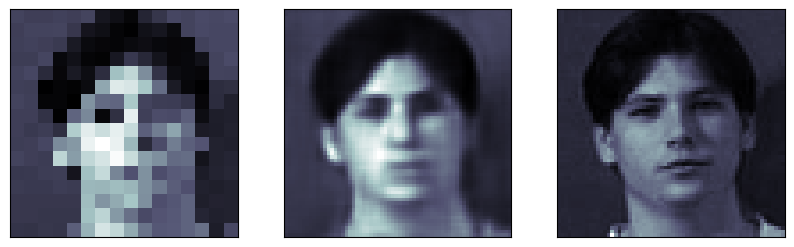

4 :	input		      prediction		  target


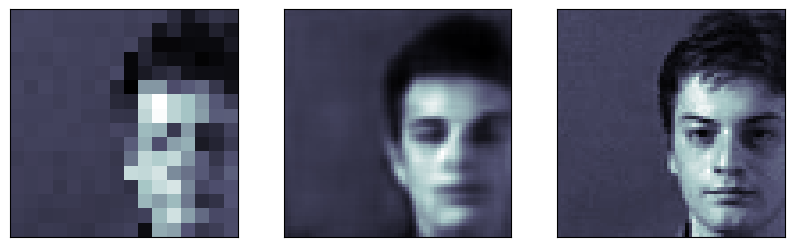

5 :	input		      prediction		  target


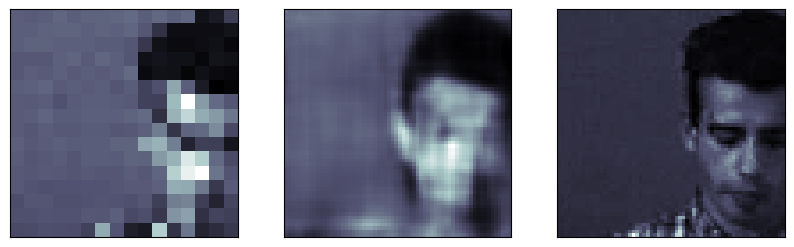

6 :	input		      prediction		  target


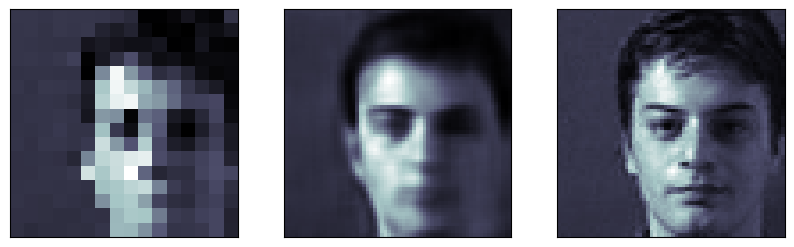

7 :	input		      prediction		  target


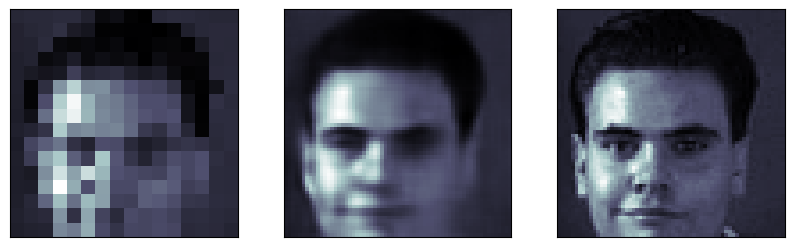

8 :	input		      prediction		  target


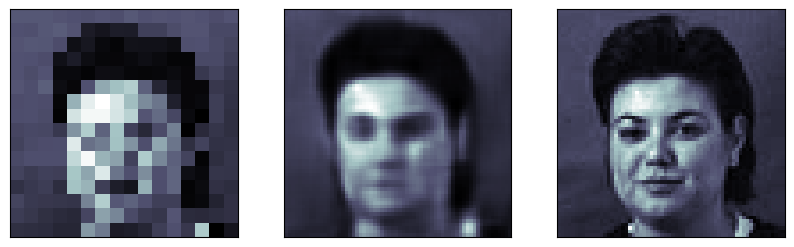

9 :	input		      prediction		  target


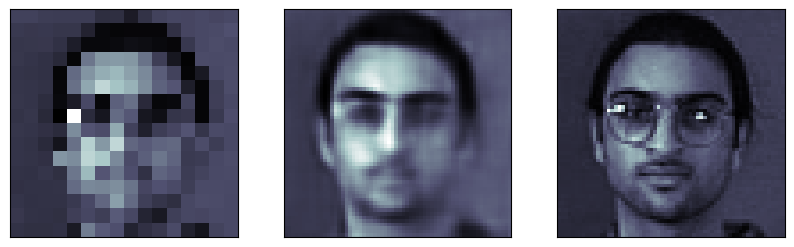

10 :	input		      prediction		  target


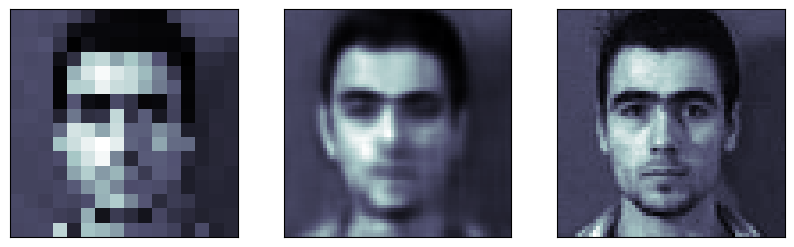

11 :	input		      prediction		  target


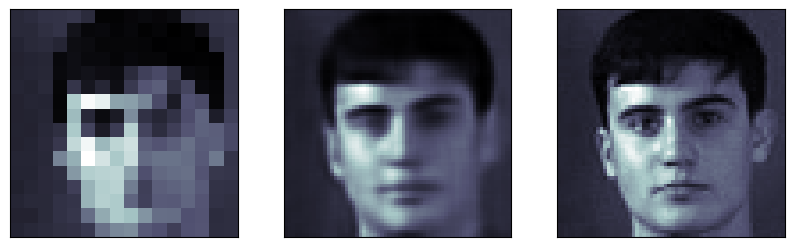

12 :	input		      prediction		  target


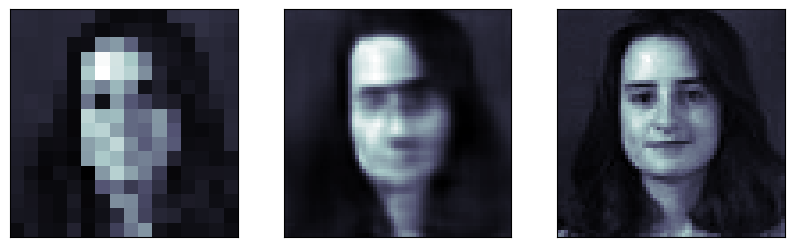

In [38]:
np.random.seed(302)
# pick a few random test images
for i in range(1, len(X_te)):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(i, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

#5 IS THIS NN TRANSFERABLE? test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [39]:
from google.colab import files
from io import BytesIO
from PIL import Image
uploaded = files.upload()


Saving headshot.png to headshot (1).png


In [40]:
file_contents = uploaded[list(uploaded.keys())[0]]


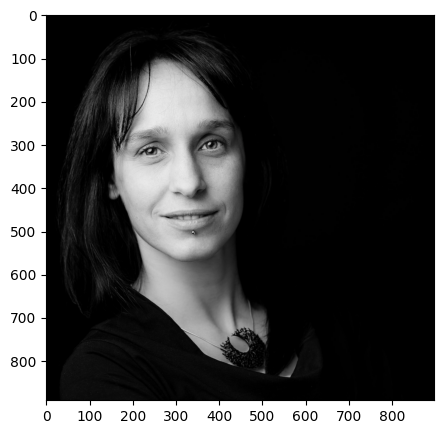

In [41]:
imme = Image.open(BytesIO(file_contents))
plt.imshow(imme)

(320, 320, 1)

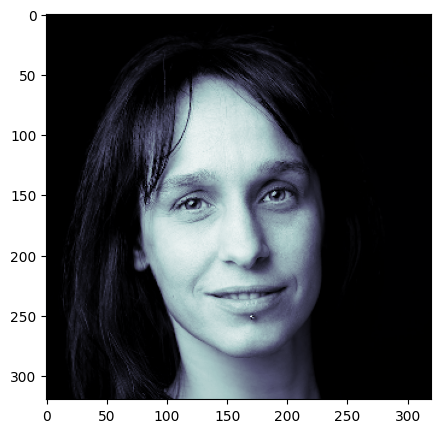

In [47]:
np_im = numpy.array(imme)[:640:2,:640:2].astype(float) / 255
np_im = np_im.mean(axis=2, keepdims=True)
pl.figure()
pl.imshow(np_im, cmap="bone");
np_im.shape

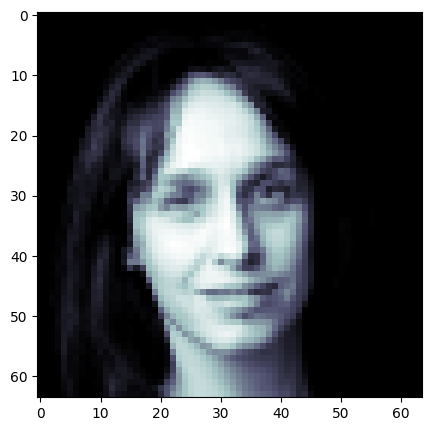

In [48]:
# prompt: resample array to decrease size to 64x64 with average filter
from skimage.measure import block_reduce

# Assuming np_im is your original array
np_im_resized = block_reduce(np_im, 5, np.mean)

plt.imshow(np_im_resized, cmap="bone")


low resolution version
subsampling by 15

In [49]:
np_im_me = np_im_resized[::4, ::4, :]#[::15,::15,1]
np_im_me.shape

(16, 16, 1)

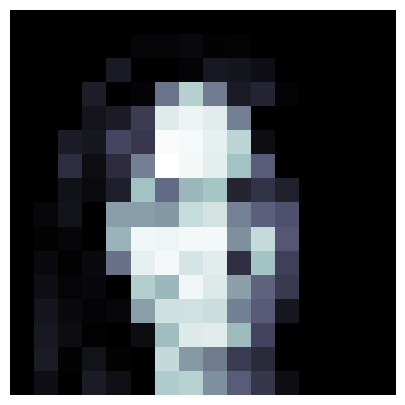

In [50]:
pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


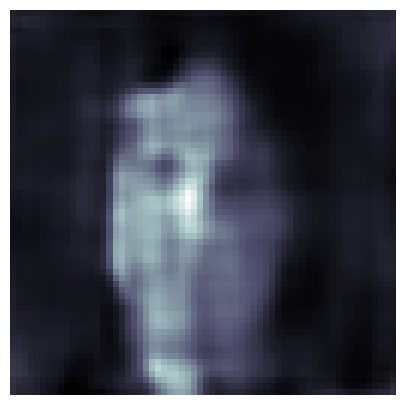

In [51]:
pl.imshow(model.predict(np.array([np_im_me]))[0],
          cmap="bone")
pl.axis('off');

# ... not good at all :-( why??